Welcome to the DOT processing scripts #2

This will take the binned offsets as made in #1
We will turn them into a propper DOT data set
Then we will make some current data too

Again all the actual code is in the modules

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pyproj
import scipy.io as io
import numpy as np
import pandas as pd
import os
import glob
from scipy import stats
import datetime as dt
from dateutil.relativedelta import relativedelta
from netCDF4 import Dataset
from numba import jit
# from pyhdf.SD  import *
import copy
import itertools
import scipy.io
import sys
import imp
from scipy.interpolate import griddata
import shapefile
from invoke import run
from scipy.ndimage.filters import gaussian_filter

import DOT
import grid_set as gs
import data_year as dy

In [2]:
#### DATA PATHS


# where our saved data is
offset_save_path = 'Our_new_data/Gridded_raw_DOT/harry_example/'
# offset_save_path = '/Users/H/WAVES/DOT_Processing/offsets/offsets_50km/'


Grid/projection is the same as before - important

In [3]:
#### this gets the porjection that we'll use to move the tracks to a grid
# Also is the frame work the grid is based upon
#### INTIALISE PROJECTION
m = Basemap(projection='stere', lon_0=0.0, lat_0=90, lat_ts=70, 
                height = 3335000*2, width = 3335000*2)


In [4]:
#### SET UP THE DATES
# this is the class we start process the data on
this_month = dt.datetime(2014,1,1) #start date
# and do the leg work. The important bit here is the 'relativedelta'
# sets the time period to consider for collecting tracks. 
# the relativedelta here is a bit meaningless -  ignore it the projection is the important bit
DOT_USE = DOT.grid_currents(relativedelta( days = 1),this_month,m) # track collection period


In [5]:
#### NEW GRID
# creates a grid/mask/extra grid info (shape etc)
# relies on the grid_set module
# once the grids have been made, they can be saved, the reloaded to save time.
DOT_USE.set_grid_dxy(50e3,50e3)
# data_month.get_grid_info()
# data_month.save_grid("grids/Polar_stereo_50km.npz")
DOT_USE.load_grid("grids/Polar_stereo_50km.npz")

# Also for masks
#### IMPORTANT: INFLATE THE MASK BY 100km for this notebook
### note masks don't currently work for the antartic because basemap
# DOT_USE.get_grid_mask(inflate = 100e3)
# DOT_USE.save_mask("grids/Polar_stereo_50km_mask_inf_100km.npz")
# data_month.load_mask("grids/Polar_stereo_50km_mask_inf_100km.npz")

DOT_USE.check_grid()

Got a grid res =  134  x  134
Note that all grid info is in ny x nx grids, whilst data is in nx x ny
Loaded a grid: grids/Polar_stereo_50km.npz
Mask saved in grids/Polar_stereo_50km_mask_inf_100km.npz
Projection av xdim =  49776.11940298508
dxRes              =  50000.0
xdist av           =  49489.4578067645


In [6]:
# extra masking to remove trouble points
DOT_USE.mask[DOT_USE.lats>88] = np.nan
    # mask out the pixel nearest 81N 56E
DOT_USE.mask_point(54,81,inflate=20e3)

In [7]:
# these two will load up the previously saved data
# the call just needs you to tell it the directory, set above
# for this example there is only 1 month
DOT_USE.find_offsets(offset_save_path,'.npz')
DOT_USE.load_offsets(offset_save_path)

Year 0 =  2014 , File year 0 =  2014


We will now need to mak a time series of average offset to normalise the data.

For the example this is not possible as there isn't enough data - we need at least a year.

The method that calculates it saves the climatology of the mean mode offsets in a file. I have included a previously made mean offset file. We can use another method just to load it in.

In [8]:
# the save script auto generates a name from the time limits
# DOT_USE.save_offset_time(offset_save_path)
DOT_USE.load_offset_time(offset_save_path+'example_mean_offset.npz')

SAR_o offset mean =  0.03153061590764533
SAR_l offset mean =  -0.0022203755540145466
SARIN offset mean =  -0.01756171578719451


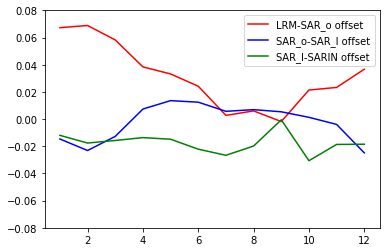

In [9]:
# mean mode offsets - if you do your own you can compare...
f = plt.figure()
ax = f.add_subplot(1,1,1)
l1=ax.plot(np.linspace(1,12,12),DOT_USE.SAR_l_off_c,'-r')
l2=ax.plot(np.linspace(1,12,12),DOT_USE.SAR_o_off_c,'-b')
l3=ax.plot(np.linspace(1,12,12),DOT_USE.SARIN_off_c,'-g')
ax.yaxis.axes.set_ylim([-0.08,0.08])
ax.legend(('LRM-SAR_o offset','SAR_o-SAR_l offset','SAR_l-SARIN offset'))
plt.show()

We can now start to process the data into a DOT product

There are some steps to be care of
1. we need to say where each mode is acceptable to be used, sometimes the modes are different (LRM over sea ice for example) and we don't want that. So get rid of those bits
There is a script to make some mode_masks from the data. But I've also included some.
2. We also set what is the minimum number of binned reocrds we consider appropriate to process. This is set in the method call.

In [10]:
### first call makes the mode masks, option to save them
# DOT_USE.mode_masks(save=True,
#         file ="grids/PS_50km_DOT_mode_masks.npz")
### second loads the previously save masks
DOT_USE.load_mode_masks("grids/PS_50km_DOT_mode_masks.npz")
# then process the DOT from the mode masks - 
DOT_USE.get_weights_DOT(mode_mask = True,weight_lim = 10)

Data size =  134 134 , mask size =  134 134


/Users/H/WAVES/DOT_Ekman_manual/DOT.py:271: RuntimeWarning: invalid value encountered in true_divide
  LRM___w = self.LRM_sla_bin_count/total_w
/Users/H/WAVES/DOT_Ekman_manual/DOT.py:272: RuntimeWarning: invalid value encountered in true_divide
  SAR_o_w = self.SAR_o_sla_bin_count/total_w
/Users/H/WAVES/DOT_Ekman_manual/DOT.py:273: RuntimeWarning: invalid value encountered in true_divide
  SAR_l_w = self.SAR_l_sla_bin_count/total_w
/Users/H/WAVES/DOT_Ekman_manual/DOT.py:274: RuntimeWarning: invalid value encountered in true_divide
  SARIN_w = self.SARIN_sla_bin_count/total_w


Things to try:
1. fiddle with the mode masks - or don't use them
2. set the weight_lim to include/remove the bad data
3. plot the various data weights to see where which data are. You'll have to look at what data is in the classes, have a dig,it's all there.
4. remember to traspose the data before you plot it. basemap like that for some reason.

Now we have the complete DOT, but it's really noisey/ripply due to geoid/physics/continental shelves

Have a look!

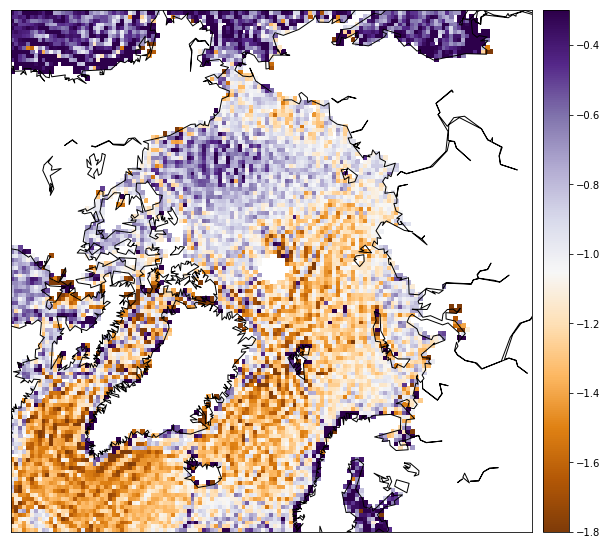

In [11]:
fig_dir = offset_save_path
res=17
t_p = 0
# some of these options are used in the default case
# the DOT is in 'data_year' format
# this masks it all and allows you to average it in a clever way
# but the default case has only one time - so meaningless
periods = np.arange(0,3)
f=plt.figure(figsize=[10,10])

m.pcolormesh(DOT_USE.xpts,DOT_USE.ypts,
        DOT_USE.DOT[t_p,:,:].T
             # in case you want to look at all the bits
#         DOT_USE.LRM_DOT_bin[t_p].T
             ### next commented bit does a climatalogical mean
             ### the periods bit sets which months are required
#         DOT_USE.DOT.clim_map(periods,
#             mask=True).T
             ,vmin = -1.8,vmax = -0.3
#              ,vmin = -2.0,vmax = 2.0
#              ,vmin = -0.2,vmax = 0.2
#              ,vmin = -1.2,vmax = -1.3
                 ,cmap='PuOr',rasterized=True)
m.colorbar()
m.drawcoastlines()
plt.show()
# f.savefig(fig_dir+'DOT_raw_2011_07.pdf')

Now we need to smooth the DOT

There is a mehtod for that.

In [12]:
# First we need to set some information
# to smooth we first need to set the limits of what data is acceptable
# option one, mean+-2*std
DOT_m = np.nanmean(DOT_USE.DOT[t_p,:,:])
DOT_s = np.nanstd(DOT_USE.DOT[t_p,:,:])
DOT_q1 = DOT_m - 2*DOT_s
DOT_q3 = DOT_m + 2*DOT_s
# or perhaps the quartile ranges?
DOT_q1,DOT_q3 = np.nanpercentile(DOT_USE.DOT[t_p,:,:],[25,75])
# or 2/98 percentile?
DOT_q1,DOT_q3 = np.nanpercentile(DOT_USE.DOT[t_p,:,:],[2,98])
# options here smoothing radius,[limits],whether to use the land mask,time points to consider
# delete n_use from here if you want to do all the time points
DOT_USE.filt_DOT(150e3,[DOT_q1,DOT_q3],mask=False,n_use = [0,1])

/Users/H/WAVES/geo_data_group/grid_set.py:422: RuntimeWarning: invalid value encountered in less
  array_2[array<limits[0]] = np.nan
/Users/H/WAVES/geo_data_group/grid_set.py:423: RuntimeWarning: invalid value encountered in greater
  array_2[array>limits[1]] = np.nan


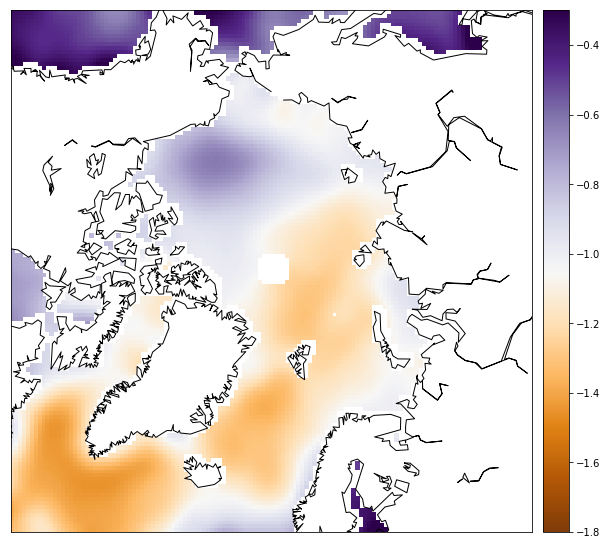

In [13]:
fig_dir = offset_save_path
res=17
t_p = 0
# some of these options are used in the default case
# the DOT is in 'data_year' format
# this masks it all and allows you to average it in a clever way
# but the default case has only one time - so meaningless
periods = np.arange(0,3)
f=plt.figure(figsize=[10,10])

m.pcolormesh(DOT_USE.xpts,DOT_USE.ypts,
        DOT_USE.DOT_filt[t_p,:,:].T
             # in case you want to look at all the bits
#         DOT_USE.LRM_DOT_bin[t_p].T
             ### next commented bit does a climatalogical mean
             ### the periods bit sets which months are required
#         DOT_USE.DOT.clim_map(periods,
#             mask=True).T
             ,vmin = -1.8,vmax = -0.3
#              ,vmin = -2.0,vmax = 2.0
#              ,vmin = -0.2,vmax = 0.2
#              ,vmin = -1.2,vmax = -1.3
                 ,cmap='PuOr',rasterized=True)
m.colorbar()
m.drawcoastlines()
plt.show()
# f.savefig(fig_dir+'DOT_raw_2011_07.pdf')

In [14]:
# now a method to get currents
# again the n_use is just for trouble shooting if you just want to porcess one time-point
DOT_USE.get_currents(n_use = [0,1])

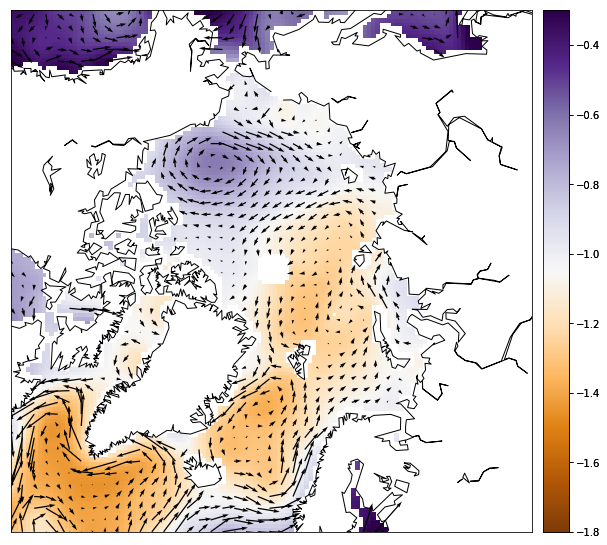

In [15]:
fig_dir = offset_save_path
res=3
t_p = 0
# some of these options are used in the default case
# the DOT is in 'data_year' format
# this masks it all and allows you to average it in a clever way
# but the default case has only one time - so meaningless
periods = np.arange(0,3)
f=plt.figure(figsize=[10,10])

m.pcolormesh(DOT_USE.xpts,DOT_USE.ypts,
        DOT_USE.DOT_filt[t_p,:,:].T
             # in case you want to look at all the bits
#         DOT_USE.LRM_DOT_bin[t_p].T
             ### next commented bit does a climatalogical mean
             ### the periods bit sets which months are required
#         DOT_USE.DOT.clim_map(periods,
#             mask=True).T
             ,vmin = -1.8,vmax = -0.3
#              ,vmin = -2.0,vmax = 2.0
#              ,vmin = -0.2,vmax = 0.2
#              ,vmin = -1.2,vmax = -1.3
                 ,cmap='PuOr',rasterized=True)
tx,ty = DOT_USE.geo_currents[t_p,:,:]
m.quiver(DOT_USE.xpts[::res,::res],DOT_USE.ypts[::res,::res],
             tx[::res,::res].T,
             ty[::res,::res].T,
             scale=0.2, scale_units='inches')
m.colorbar()
m.colorbar()
m.drawcoastlines()
plt.show()
# f.savefig(fig_dir+'DOT_raw_2011_07.pdf')

/Users/H/WAVES/DOT_Ekman_manual/data_year.py:517: RuntimeWarning: Mean of empty slice
  axis = 0)


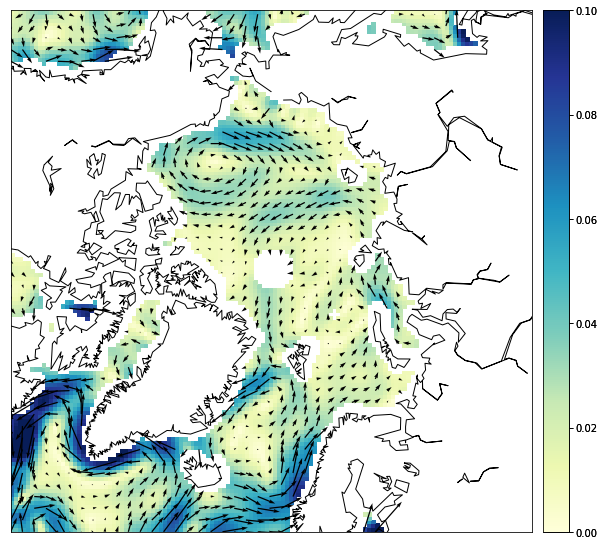

In [16]:
# And now over current speed
fig_dir = offset_save_path
res=3
t_p = 0
# some of these options are used in the default case
# the DOT is in 'data_year' format
# this masks it all and allows you to average it in a clever way
# but the default case has only one time - so meaningless
periods = np.arange(0,3)
f=plt.figure(figsize=[10,10])

m.pcolormesh(DOT_USE.xpts,DOT_USE.ypts,
        DOT_USE.geo_currents.clim_map([0],time_set=[0,1],magnitude=True).T
             # in case you want to look at all the bits
#         DOT_USE.LRM_DOT_bin[t_p].T
             ### next commented bit does a climatalogical mean
             ### the periods bit sets which months are required
#         DOT_USE.DOT.clim_map(periods,
#             mask=True).T
             ,vmin = 0.0,vmax = 0.1
                 ,cmap='YlGnBu',rasterized=True)
tx,ty = DOT_USE.geo_currents[t_p,:,:]
m.quiver(DOT_USE.xpts[::res,::res],DOT_USE.ypts[::res,::res],
             tx[::res,::res].T,
             ty[::res,::res].T,
             scale=0.2, scale_units='inches')
m.colorbar()
m.drawcoastlines()
plt.show()
# f.savefig(fig_dir+'DOT_raw_2011_07.pdf')

In [20]:
# now as the DOT and DOT_filt and geo_currents are data_year objects they have handy save methods
data_save = 'Our_new_data/Smooth_DOT/harry_example/'
t_p = 0
filename = data_save+DOT_USE.DOT.dates[t_p].strftime('%Y%m')+DOT_USE.DOT.dates[-1].strftime('%Y%m')+'DOT_raw.npz'
DOT_USE.DOT.save(filename)
filename = data_save+DOT_USE.DOT_filt.dates[t_p].strftime('%Y%m')+DOT_USE.DOT_filt.dates[-1].strftime('%Y%m')+'DOT_smooth.npz'
DOT_USE.DOT_filt.save(filename)
filename = data_save+DOT_USE.geo_currents.dates[t_p].strftime('%Y%m')+DOT_USE.geo_currents.dates[-1].strftime('%Y%m')+'geo_current.npz'
DOT_USE.geo_currents.save(filename)

SyntaxError: invalid syntax (<ipython-input-20-1f1a8ac8dbe8>, line 4)

In [ ]:
#### SOME ADITIONAL SCRIPTS TO READ TOMS DOT

#### THIS BIT READS IT IN AND REGRIDS TO ALL ABOVE
# old_DOT_dir = '2014_data/Toms_DOT/'
# # grid_xy=np.genfromtxt(old_DOT_dir+'lonlat_gt60.xy')
# files = glob.glob(old_DOT_dir+'*.xyz')
# n_t = 0
# dates = []
# for file in files: 
# #     if dbug: print(file) 
#     try:
#         date_str = file.split('month')[1]
#         date_str = date_str.split('.xyz')[0]
#         date_use = dt.datetime.strptime(date_str,'%Y%m')
# #     if dbug: print(date_str) 
#     except ValueError:
#         pass
#     except IndexError:
#         pass
#     else:
#         n_t += 1
#         dates.append(date_use)
# dates.sort()
# print(n_t)

# date_cut = dates[0:2]
# old_DOT_raw = []
# for tt,date in enumerate(dates):
# # for tt,date in enumerate(date_cut):
#     file = old_DOT_dir+'month'+date.strftime('%Y%m')+'.xyz'
#     data_now = np.genfromtxt(file)
#     old_DOT_raw.append(data_now[:,2])

# Toms_DOT = gs.regrid_data(old_DOT_raw,dates,
#             data_now[:,0],data_now[:,1],off_L[0],12)

# temp_mask = np.ones_like(off_L[0].lats)
# temp_mask[off_L[0].lats>81.5] = np.nan
# Toms_DOT.build_static_mask(temp_mask)

#### IT'S NOW A DATA YEAR SO ALL THE LOVELY METHODS

# filename = 'Tom_DOT_polar_stereo_50km.npz'
# Toms_DOT.save(filename)
# Toms_DOT = dy.load_data_year(filename)

##### MAYBE SUCK OUT THE CURRENTS - USING DOT.py methods, to get a vec_data_year???